In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt


# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

# 导入模型
from src.Bayesian_recon import *

In [2]:
import src.Bayesian_recon.problems.model as model
from src.Bayesian_recon.problems.model import StandardModel as Model

import src.Bayesian_recon.problems.config as config
from src.Bayesian_recon.problems.config import config_fgt

from src.Bayesian_recon.problems import *

In [3]:
from src.Bayesian_recon.utils.optimizer import Optimizer

module_config = {
    "cluster": (PartitionCluster, {
        "amount_range": [(0, 5), (0, 5), (0, 5)],
        "transition_spec": ["posterior_random", "ksimilar_centers", "random"]
    }),
    "memory": (BaseMemory, {
        "personal_memory_range": {"gamma": (0.1, 1.0), "w0": (0.01, 0.1)},
        "param_resolution": 10
    })
}
optimizer = Optimizer(module_config, n_jobs=100)
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

In [ ]:
res = optimizer.optimize_params_with_subs_parallel(
    config_fgt,
    # [1,4]
    list(range(1, 25)) 
)

Processing tasks:   1%|▍                                    | 5900/516000 [04:06<4:08:12, 34.25it/s]

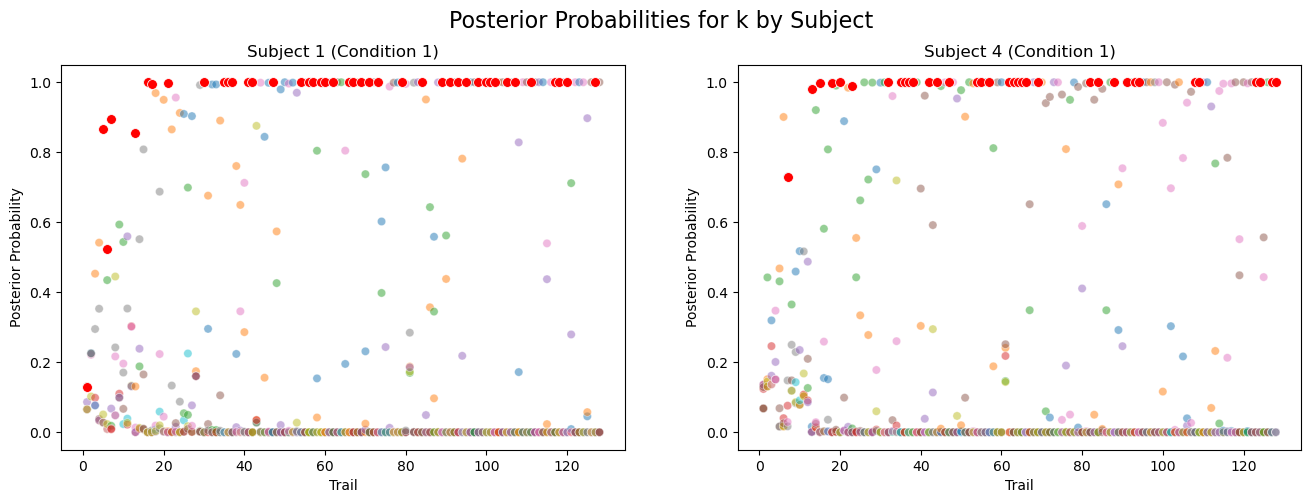

In [5]:
optimizer.plot_posterior_probabilities(
    res,[1,4])

In [27]:
optimizer.set_results(res)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt,
    [1,4],
)

Predicting tasks: 100%|███████████████████████████████████████████████| 2/2 [00:00<00:00, 30.50it/s]


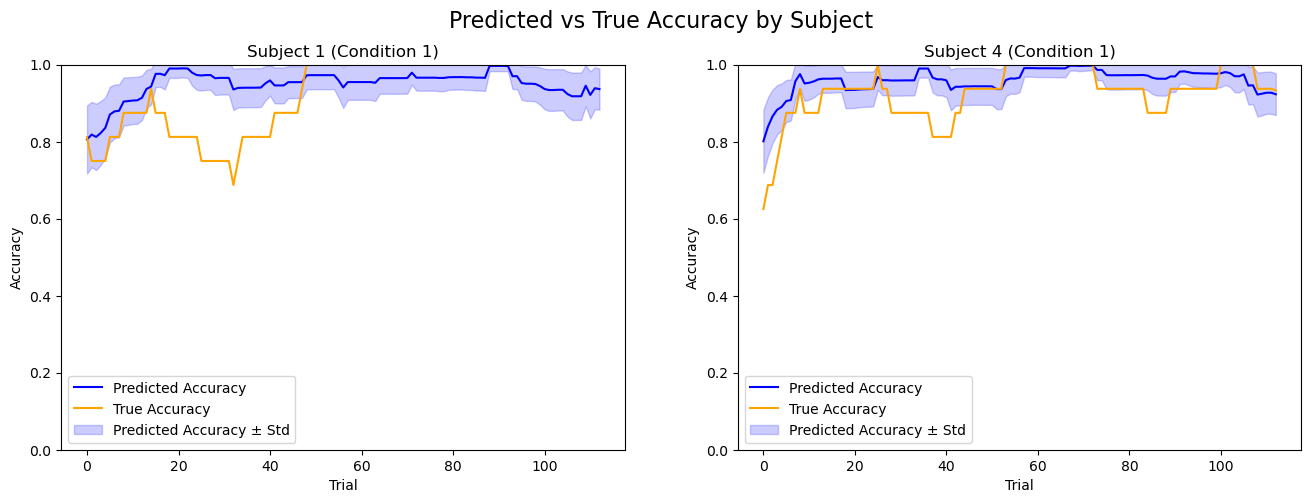

In [30]:
optimizer.plot_accuracy_comparison(prediction)

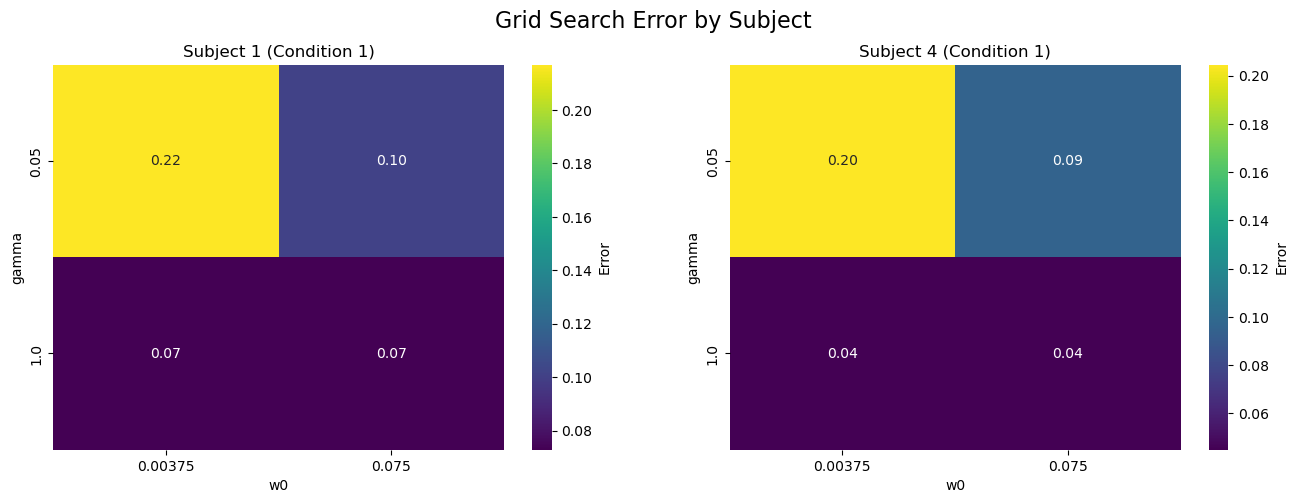

In [43]:
optimizer.plot_error_grids(res)